In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
import matplotlib
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.offsetbox import AnchoredText
import os

In [2]:
matplotlib.rc('font',size=17)

In [3]:
#colour map setup
cmap = plt.cm.get_cmap("viridis")

my_cmap = cmap(np.arange(cmap.N))
alphas = np.linspace(0.6,0.6,cmap.N)
BG = np.asarray([1.,1.,1.])
for i in range(cmap.N):
    my_cmap[i,:-1] = my_cmap[i,:-1] * alphas[i] + BG*(1.-alphas[i])
my_cmap = ListedColormap(my_cmap)
cmap=my_cmap

In [4]:
#User-defined values for the Av,obs - PDF shape and metallicity
av_bar = 1.4 #mean
s = 0.42 #width (sigma)
metallicity = 1.0 #allowed values: 0.1, 0.5, 1.0, 2.0
#any other metallicity value will return a "512" signal and the algorithm won't run

In [5]:
writeout = np.column_stack((av_bar,s,metallicity))
np.savetxt('pdfchem.params',writeout,delimiter=' ',fmt='%1.4e')

In [6]:
#You need to compile the algorithm (using gfortran) first to be able to run it
#Compiling the algorithm: in a terminal and while in the directory of PDFchem,
#                         type 'gfortran -o pdfchem_algorithm pdfchem_algorithm.f90'
os.system('./pdfchem_algorithm')
#successful runs return "0" signal after ~30 seconds depending on your machine

0

In [7]:
inputfile = 'output.dat'
title = r'PDFchem result'

In [8]:
#CHEMISTRY RESULTS
d = np.genfromtxt(inputfile)

#UV radiation (Draine); cosmic-ray ionization rate (s-1); metallicity (Zsolar)
UV = d[:,0]; CR = d[:,1]; Z = d[:,2]
#Gas temperature
Tgas = d[:,3]
#Abundances of CII; CI; CO; OI; HI; H2; OH+; H2O+; OH; CH; HCO+
CII = d[:,14]; CI = d[:,28]; CO = d[:,31]
OI = d[:,33]; HI = d[:,35]; H2 = d[:,34]
OHp = d[:,12]; H2Op = d[:,16]; OH = d[:,32]
CH = d[:,24]; HCOp = d[:,26]
#the above are some of the available species
#follow the sequence of species by adding 3 to plot any other available

#Brightness temperatures of [CII]158; [CI](1-0); [CI](2-1)
Tcii = d[:,37]; Tci10 = d[:,38]; Tci21 = d[:,39]
#CO(1-0); CO(2-1); ... CO(10-9)
Tco10 = d[:,40]; Tco21 = d[:,41]; Tco32 = d[:,42] 
Tco43 = d[:,43]; Tco54 = d[:,44]; Tco65 = d[:,45]
Tco76 = d[:,46]; Tco87 = d[:,47]; Tco98 = d[:,48]
Tco109 = d[:,49]


#AV-PDF 
d = np.genfromtxt('avpdf.dat')
av = d[:,0]; pdf = d[:,1]

Text(0.5,1,u"('Mean=', 1.4, 'width=', 0.42)")

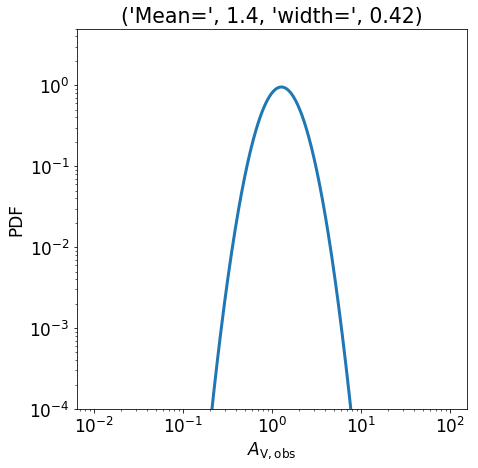

In [9]:
#Plot the user-defined Av,obs -- PDF

plt.figure(figsize=(7,7))
plt.loglog(av,pdf,'-',lw=3)
plt.ylim(1e-4,5)
plt.xlabel(r'$A_{\rm V,obs}$')
plt.ylabel(r'PDF')
plt.title(('Mean=',av_bar, 'width=',s))

In [10]:
#for plotting the grid
xi = np.linspace(min(np.log10(CR)), max(np.log10(CR)), 50)
yi = np.linspace(min(np.log10(UV)), max(np.log10(UV)), 50)

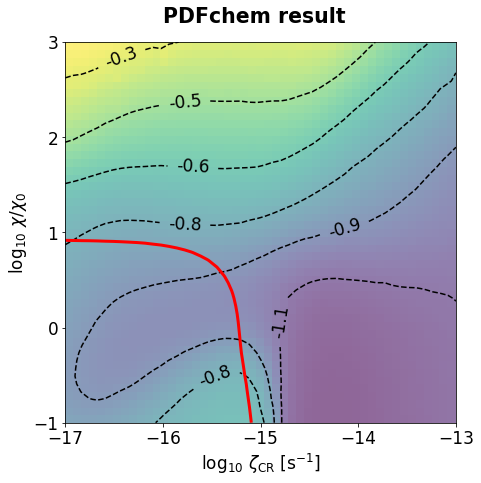

In [11]:
#Individual plot

#Enter quantity to plot (ratios are generally preferred, especially
#                        for brightness temperatures)
qty = Tco21/Tco10 #e.g. 'CO' for CO abundance, 'Tco21/Tco10' for CO(2-1)/CO(1-0)

plt.figure(figsize=(7,7))
N=6 #No. contours

#HI-H2 transition
zi_tr = ml.griddata(np.log10(CR),np.log10(UV),np.log10(HI/2./H2),xi,yi,interp='linear') 
#make grid of the quantity qty
zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(qty),xi,yi,interp='linear')
plt.pcolormesh(xi,yi,zi,cmap=cmap)
CS = plt.contour(xi,yi,zi,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
plt.contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0) #plot HI-H2 transition (red line)
plt.xticks([-17,-16,-15,-14,-13])
plt.yticks([-1,0,1,2,3])
plt.xlabel(r'$\log_{10}\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
plt.ylabel(r'$\log_{10}\,\,\chi/\chi_0$')
plt.suptitle(title,weight='bold',y=0.95)

plt.savefig('Individual.png',bbox_inches='tight')

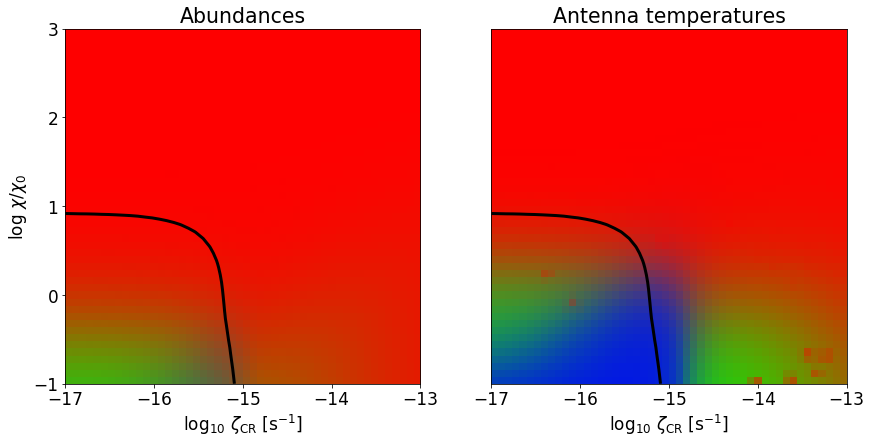

In [12]:
#carbon cycle map
fig, axs = plt.subplots(1,2,figsize=(14,7))

#HI-H2 transition
zi_tr = ml.griddata(np.log10(CR),np.log10(UV),np.log10(HI/2./H2),xi,yi,interp='linear') 

#RED: CII and [CII]
#GREEN: CI and [CI](1-0)
#BLUE: CO and CO(1-0)

#Abundances
tot_carbon = CII+CI+CO
cii_norm = ml.griddata(np.log10(CR),np.log10(UV),CII/tot_carbon,xi,yi,interp='linear')
ci_norm = ml.griddata(np.log10(CR),np.log10(UV),CI/tot_carbon,xi,yi,interp='linear')
co_norm = ml.griddata(np.log10(CR),np.log10(UV),CO/tot_carbon,xi,yi,interp='linear')
axs[0].imshow(np.dstack([cii_norm,ci_norm,co_norm]),origin='lower',extent=[-17,-13,-1,3])
axs[0].contour(xi,yi,zi_tr,[0],colors='k',linewidths=3.0)
axs[0].set_xticks([-17,-16,-15,-14,-13])
axs[0].set_yticks([-1,0,1,2,3])
axs[0].set_ylabel(r'$\log\,\,\chi/\chi_0$')
axs[0].set_xlabel(r'$\log_{10}\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
axs[0].set_title(r'Abundances')

#Abundances
tot_Tcarbon = Tcii+Tci10+Tco10
cii_norm = ml.griddata(np.log10(CR),np.log10(UV),Tcii/tot_Tcarbon,xi,yi,interp='linear')
ci_norm = ml.griddata(np.log10(CR),np.log10(UV),Tci10/tot_Tcarbon,xi,yi,interp='linear')
co_norm = ml.griddata(np.log10(CR),np.log10(UV),Tco10/tot_Tcarbon,xi,yi,interp='linear')
axs[1].imshow(np.dstack([cii_norm,ci_norm,co_norm]),origin='lower',extent=[-17,-13,-1,3])
axs[1].contour(xi,yi,zi_tr,[0],colors='k',linewidths=3.0)
axs[1].set_xticks([-17,-16,-15,-14,-13])
axs[1].set_yticks([])
axs[1].set_xlabel(r'$\log_{10}\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
axs[1].set_title(r'Antenna temperatures')

plt.savefig('Carbon_maps.png',bbox_inches='tight')

/usr/lib/python2.7/dist-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


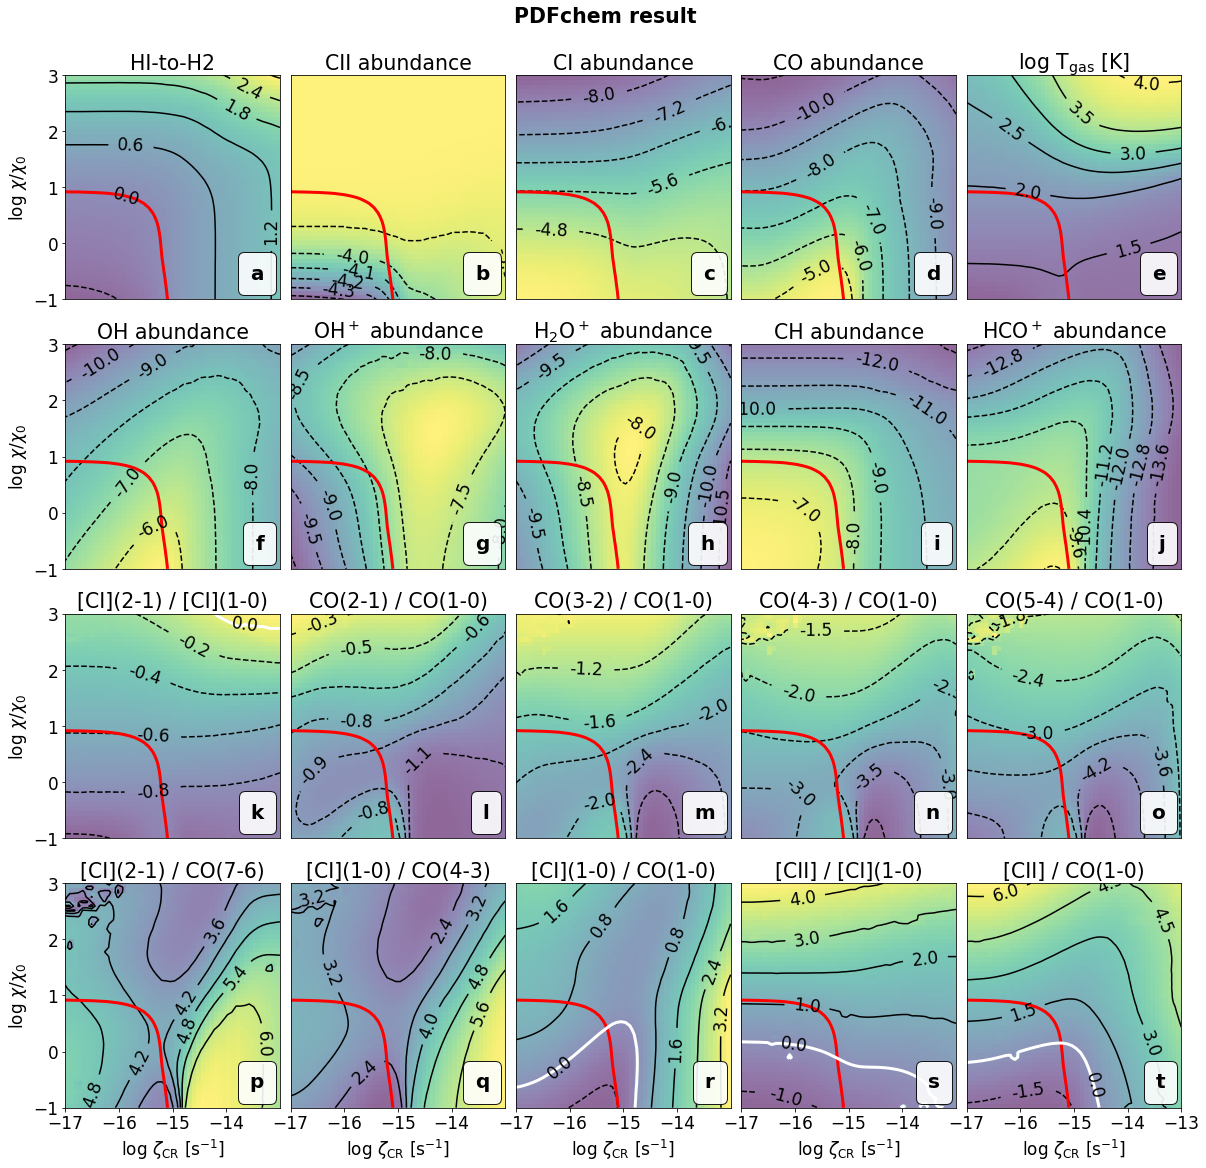

In [13]:
#Collective plot similar to paper

fig, axs = plt.subplots(4, 5, figsize=(20,19))

xt = -16.85; yt = -0.65
N=6

zi_tr = ml.griddata(np.log10(CR),np.log10(UV),np.log10(HI/2./H2),xi,yi,interp='linear')
axs[0,0].pcolormesh(xi,yi,zi_tr,cmap=cmap)
CS = axs[0,0].contour(xi,yi,zi_tr,N,colors='k')
axs[0,0].clabel(CS,fmt='%1.1f')
CS = axs[0,0].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
text_box = AnchoredText("a", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[0,0].add_artist(text_box)
axs[0,0].set_xticks([])
axs[0,0].set_yticks([-1, 0, 1, 2, 3])
axs[0,0].set_ylabel(r'$\log\,\,\chi/\chi_0$')
axs[0,0].set_title('HI-to-H2')

zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(CII),xi,yi,interp='linear')
axs[0,1].pcolormesh(xi,yi,zi,cmap=cmap)
CS = axs[0,1].contour(xi,yi,zi,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
CS = axs[0,1].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
text_box = AnchoredText("b", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[0,1].add_artist(text_box)
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
axs[0,1].set_title('CII abundance')

zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(CI),xi,yi,interp='linear')
axs[0,2].pcolormesh(xi,yi,zi,cmap=cmap)
CS = axs[0,2].contour(xi,yi,zi,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
CS = axs[0,2].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
text_box = AnchoredText("c", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[0,2].add_artist(text_box)
axs[0,2].set_xticks([])
axs[0,2].set_yticks([])
axs[0,2].set_title('CI abundance')

zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(CO),xi,yi,interp='linear')
axs[0,3].pcolormesh(xi,yi,zi,cmap=cmap)
CS = axs[0,3].contour(xi,yi,zi,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
CS = axs[0,3].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
text_box = AnchoredText("d", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[0,3].add_artist(text_box)
axs[0,3].set_xticks([])
axs[0,3].set_yticks([])
axs[0,3].set_title('CO abundance')

zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tgas),xi,yi,interp='linear')
axs[0,4].pcolormesh(xi,yi,zi,cmap=cmap)
CS = axs[0,4].contour(xi,yi,zi,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
CS = axs[0,4].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
text_box = AnchoredText("e", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[0,4].add_artist(text_box)
axs[0,4].set_xticks([])
axs[0,4].set_yticks([])
axs[0,4].set_title(r'log T$_{\rm gas}$ [K]')

zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(OH),xi,yi,interp='linear')
axs[1,0].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[1,0].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[1,0].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[1,0].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("f", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[1,0].add_artist(text_box)
axs[1,0].set_xticks([])
axs[1,0].set_yticks([-1, 0, 1, 2, 3])
axs[1,0].set_ylabel(r'$\log\,\,\chi/\chi_0$')
axs[1,0].set_title('OH abundance')

zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(OHp),xi,yi,interp='linear')
axs[1,1].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[1,1].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[1,1].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[1,1].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("g", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[1,1].add_artist(text_box)
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])
axs[1,1].set_title(r'OH$^+$ abundance')

zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(H2Op),xi,yi,interp='linear')
axs[1,2].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[1,2].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[1,2].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[1,2].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("h", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[1,2].add_artist(text_box)
axs[1,2].set_xticks([])
axs[1,2].set_yticks([])
axs[1,2].set_title(r'H$_2$O$^+$ abundance')

zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(CH),xi,yi,interp='linear')
axs[1,3].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[1,3].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[1,3].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[1,3].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("i", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[1,3].add_artist(text_box)
axs[1,3].set_xticks([])
axs[1,3].set_yticks([])
axs[1,3].set_title('CH abundance')

zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(HCOp),xi,yi,interp='linear')
axs[1,4].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[1,4].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[1,4].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[1,4].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("j", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[1,4].add_artist(text_box)
axs[1,4].set_xticks([])
axs[1,4].set_yticks([])
axs[1,4].set_title(r'HCO$^+$ abundance')

zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tci21/Tci10),xi,yi,interp='linear')
axs[2,0].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[2,0].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[2,0].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[2,0].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("k", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[2,0].add_artist(text_box)
axs[2,0].set_xticks([])
axs[2,0].set_yticks([-1, 0, 1, 2, 3])
axs[2,0].set_ylabel(r'$\log\,\,\chi/\chi_0$')
axs[2,0].set_title('[CI](2-1) / [CI](1-0)')

zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tco21/Tco10),xi,yi,interp='linear')
axs[2,1].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[2,1].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[2,1].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[2,1].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("l", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[2,1].add_artist(text_box)
axs[2,1].set_xticks([])
axs[2,1].set_yticks([])
axs[2,1].set_title('CO(2-1) / CO(1-0)')

zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tco32/Tco10),xi,yi,interp='linear')
axs[2,2].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[2,2].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[2,2].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[2,2].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("m", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[2,2].add_artist(text_box)
axs[2,2].set_xticks([])
axs[2,2].set_yticks([])
axs[2,2].set_title('CO(3-2) / CO(1-0)')

zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tco43/Tco10),xi,yi,interp='linear')
axs[2,3].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[2,3].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[2,3].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[2,3].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("n", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[2,3].add_artist(text_box)
axs[2,3].set_xticks([])
axs[2,3].set_yticks([])
axs[2,3].set_title('CO(4-3) / CO(1-0)')

zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tco54/Tco10),xi,yi,interp='linear')
axs[2,4].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[2,4].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[2,4].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[2,4].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("o", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[2,4].add_artist(text_box)
axs[2,4].set_xticks([])
axs[2,4].set_yticks([])
axs[2,4].set_title(r'CO(5-4) / CO(1-0)')

zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tci21/Tco76),xi,yi,interp='linear')
axs[3,0].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[3,0].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[3,0].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[3,0].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("p", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[3,0].add_artist(text_box)
axs[3,0].set_xticks([-17, -16, -15, -14])
axs[3,0].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
axs[3,0].set_yticks([-1, 0, 1, 2, 3])
axs[3,0].set_title(r'[CI](2-1) / CO(7-6)')
axs[3,0].set_ylabel(r'$\log\,\,\chi/\chi_0$')
axs[3,0].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')

zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tci10/Tco43),xi,yi,interp='linear')
axs[3,1].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[3,1].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[3,1].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[3,1].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("q", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[3,1].add_artist(text_box)
axs[3,1].set_xticks([-17, -16, -15, -14])
axs[3,1].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
axs[3,1].set_yticks([])
axs[3,1].set_title(r'[CI](1-0) / CO(4-3)')

zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tci10/Tco10),xi,yi,interp='linear')
axs[3,2].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[3,2].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[3,2].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[3,2].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("r", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[3,2].add_artist(text_box)
axs[3,2].set_xticks([-17, -16, -15, -14])
axs[3,2].set_yticks([])
axs[3,2].set_title(r'[CI](1-0) / CO(1-0)')
axs[3,2].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')

zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tcii/Tci10),xi,yi,interp='linear')
axs[3,3].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[3,3].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[3,3].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[3,3].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("s", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[3,3].add_artist(text_box)
axs[3,3].set_xticks([-17, -16, -15, -14])
axs[3,3].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
axs[3,3].set_yticks([])
axs[3,3].set_title(r'[CII] / [CI](1-0)')

zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tcii/Tco10),xi,yi,interp='linear')
axs[3,4].pcolormesh(xi,yi,zi_R,cmap=cmap)
CS = axs[3,4].contour(xi,yi,zi_R,N,colors='k')
plt.clabel(CS,fmt='%1.1f')
axs[3,4].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
axs[3,4].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
text_box = AnchoredText("t", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
axs[3,4].add_artist(text_box)
axs[3,4].set_xticks([-17, -16, -15, -14, -13])
axs[3,4].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
axs[3,4].set_yticks([])
axs[3,4].set_title(r'[CII] / CO(1-0)')


plt.subplots_adjust(wspace=0.05, hspace=0.2)
plt.suptitle(title, y=0.93, weight='bold')

plt.savefig('Collective.png',bbox_inches='tight')